#Loading dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


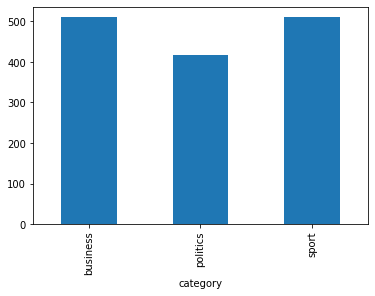

In [1]:
!pip install transformers
!pip install jax
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

bert_checkpoint = 'bert-base-cased'
roberta_checkpoint = 'roberta-base'

checkpoint = bert_checkpoint

datapath = "/content/gdrive/MyDrive/Colab Notebooks/bbc_train.csv"
df = pd.read_csv(datapath)
df.groupby(['category']).size().plot.bar()
tokenizer = BertTokenizer.from_pretrained(checkpoint)

labels = {'business':0,
          'sport':1,
          'politics':2
          # 'entertainment':3,
          # 'tech':4,
          }

In [2]:
df.head()

,id,title,text,category
0,0,Ad sales boost Time Warner profit\n,Quarterly profits at US media giant TimeWarner...,business
1,1,Dollar gains on Greenspan speech\n,The dollar has hit its highest level against t...,business
2,2,Yukos unit buyer faces loan claim\n,The owners of embattled Russian oil giant Yuko...,business
3,3,High fuel prices hit BA's profits\n,British Airways has blamed high fuel prices fo...,business
4,4,Pernod takeover talk lifts Domecq\n,Shares in UK drinks and food firm Allied Domec...,business


#Dataset class

In [3]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 256, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y


In [4]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Model definition + train and eval functions definition

In [5]:
from transformers import BertTokenizer, BertModel, AutoModelForSequenceClassification
from torch import nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassF1Score, MulticlassAUROC, MulticlassRecall, MulticlassPrecision
class TextClassifier(nn.Module): 

    def __init__(self, checkpoint, num_of_classes, dropout=0.5):

        super(TextClassifier, self).__init__()

        self.bert = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                                     num_labels=num_of_classes)
        self.num_of_labels = num_of_classes

    def forward(self, input_id, mask, labels):

        pooled_output = self.bert(input_ids=input_id, attention_mask=mask,
                                  labels=labels, return_dict=True)

        return pooled_output

In [6]:
def train(model, train_data, val_data, learning_rate, epochs, train_batch_size, val_batch_size):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=train_batch_size, shuffle=True)

    val_dataloader = torch.utils.data.DataLoader(val, batch_size=val_batch_size, shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0
            total_auc_train = 0
            total_recall_train = 0
            total_precision_train = 0
            total_f1_train = 0
            probabilities_list = []
            logits_list = []
            train_label_list=[]

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                train_label_list.append(train_label)

                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask, train_label)
             
                logits_list.append(output.logits)
                probabilities = F.softmax(output.logits, dim=1)
                probabilities_list.append(probabilities)

                loss = criterion(probabilities, train_label.long())
                
                (predictions, predictions_indicies) = torch.max(probabilities,dim=1)

                metric_aucroc = MulticlassAUROC(num_classes=model.num_of_labels).to(device)
                auroc = metric_aucroc(preds=probabilities, target=train_label,)

                metric_recall = MulticlassRecall(num_classes=model.num_of_labels).to(device)
                recall = metric_recall(preds=probabilities, target=train_label)
                
                metric_precision = MulticlassPrecision(num_classes=model.num_of_labels).to(device)
                precision = metric_precision(preds=probabilities, target=train_label)
               
                total_loss_train += loss
              
                acc = (predictions_indicies == train_label).sum().item()
                total_acc_train += acc/train_label.size(dim=0)

                total_auc_train += auroc
                total_recall_train += recall
                total_precision_train += precision
          

                model.zero_grad()
                loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0
            total_recall_val = 0
            total_precision_val = 0
            total_auc_val = 0


            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask, val_label)
                   
                    
                    probabilities = F.softmax(output.logits, dim=1)

                    loss = criterion(probabilities, val_label.long())
                   
                    (predictions, predictions_indicies) = torch.max(probabilities, dim=1)

                    metric_aucroc = MulticlassAUROC(num_classes=model.num_of_labels).to(device)
                    auroc = metric_aucroc(preds=probabilities, target=val_label)

                    metric_recall = MulticlassRecall(num_classes=model.num_of_labels).to(device)
                    recall = metric_recall(preds=probabilities, target=val_label)
                  
                    metric_precision = MulticlassPrecision(num_classes=model.num_of_labels).to(device)
                    precision = metric_precision(preds=probabilities, target=val_label)

                    total_loss_val += loss
                  
                    acc = (predictions_indicies == val_label).sum().item()
                    total_acc_val += acc/val_label.size(dim=0)

                    total_auc_val += auroc
                    total_recall_val += recall
                    total_precision_val += precision
              

            print(f"Epochs: {epoch_num + 1} | Train Accuracy: {total_acc_train / len(train_dataloader): .3f} | Train Loss: {total_loss_train / len(train_dataloader): .3f} | Train Recall: {total_recall_train / len(train_dataloader): .3f} | Train Precision: {total_precision_train / len(train_dataloader): .3f} | Train AUC: {total_auc_train/ len(train_dataloader): .3f} | Val Accuracy: {total_acc_val / len(val_dataloader): .3f} | Val Loss: {total_loss_val / len(val_dataloader): .3f} | Val Recall: {total_recall_val / len(val_dataloader): .3f} | Val Precision: {total_precision_val / len(val_dataloader): .3f} | Val AUC: {total_auc_val/ len(val_dataloader): .3f} ")
          
    return probabilities_list, logits_list, train_label_list

In [7]:
def evaluate(model, test_data, test_batch_size):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=test_batch_size, shuffle=True)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    total_auc_test = 0
    total_recall_test = 0
    total_precision_test = 0

    probabilities_list = []
    logits_list = []
    test_label_list=[]
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              test_label_list.append(test_label)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask, test_label)
              
              logits_list.append(output.logits)
              probabilities = F.softmax(output.logits, dim=1)
              probabilities_list.append(probabilities)
           
              (predictions, predictions_indicies) = torch.max(probabilities,dim=1)

              metric_aucroc = MulticlassAUROC(num_classes=model.num_of_labels).to(device)
              auroc = metric_aucroc(preds=probabilities, target=test_label)

              metric_recall = MulticlassRecall(num_classes=model.num_of_labels).to(device)
              recall = metric_recall(preds=probabilities, target=test_label)
            
              metric_precision = MulticlassPrecision(num_classes=model.num_of_labels).to(device)
              precision = metric_precision(preds=probabilities, target=test_label)

              acc = (predictions_indicies == test_label).sum().item()
              total_acc_test += acc/test_label.size(dim=0)

              total_auc_test += auroc
              total_recall_test += recall
              total_precision_test += precision
  
        print(f"Test Accuracy: {total_acc_test / len(test_label_list): .3f} | Test Recall: {total_recall_test / len(test_dataloader): .3f} | Test Precision: {total_precision_test / len(test_dataloader): .3f} |Test AUC: {total_auc_test/ len(test_dataloader): .3f}")
  
    return probabilities_list, logits_list, test_label_list

In [8]:
np.random.seed(42)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=420), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

1150 144 144


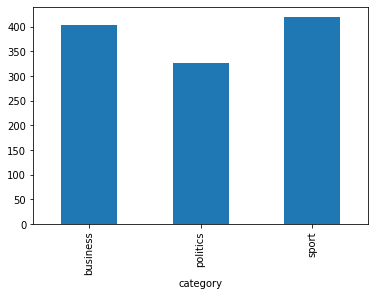

In [9]:
df_train.groupby(['category']).size().plot.bar()

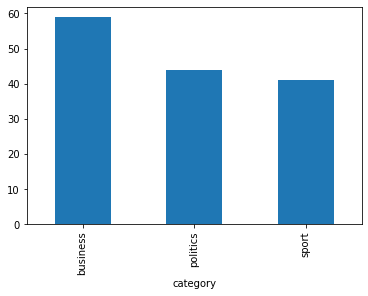

In [10]:
df_val.groupby(['category']).size().plot.bar()

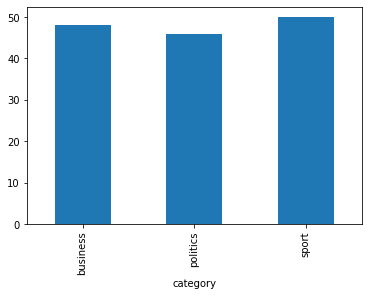

In [11]:
df_test.groupby(['category']).size().plot.bar()

#Build model

In [12]:
num_of_classes=3
model = TextClassifier(checkpoint, num_of_classes=num_of_classes)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

# Parameters

In [13]:
EPOCHS = 12
LR = 1e-6
train_batch_size = 32
val_batch_size = 32

# Train model

In [14]:
probabilities_list_train, logits_list_train, train_label_list = train(model, df_train, df_val, LR, EPOCHS, train_batch_size, val_batch_size)

100%|██████████| 36/36 [00:48<00:00,  1.35s/it]


Epochs: 1 | Train Accuracy:  0.359 | Train Loss:  1.097 | Train Recall:  0.345 | Train Precision:  0.221 | Train AUC:  0.676 | Val Accuracy:  0.481 | Val Loss:  1.074 | Val Recall:  0.396 | Val Precision:  0.394 | Val AUC:  0.855 


100%|██████████| 36/36 [00:49<00:00,  1.37s/it]


Epochs: 2 | Train Accuracy:  0.530 | Train Loss:  1.072 | Train Recall:  0.555 | Train Precision:  0.439 | Train AUC:  0.885 | Val Accuracy:  0.662 | Val Loss:  1.049 | Val Recall:  0.630 | Val Precision:  0.514 | Val AUC:  0.976 


100%|██████████| 36/36 [00:48<00:00,  1.35s/it]


Epochs: 3 | Train Accuracy:  0.716 | Train Loss:  1.028 | Train Recall:  0.734 | Train Precision:  0.703 | Train AUC:  0.965 | Val Accuracy:  0.944 | Val Loss:  0.979 | Val Recall:  0.939 | Val Precision:  0.954 | Val AUC:  0.991 


100%|██████████| 36/36 [00:48<00:00,  1.35s/it]


Epochs: 4 | Train Accuracy:  0.945 | Train Loss:  0.923 | Train Recall:  0.949 | Train Precision:  0.942 | Train AUC:  0.990 | Val Accuracy:  0.969 | Val Loss:  0.852 | Val Recall:  0.968 | Val Precision:  0.974 | Val AUC:  0.999 


100%|██████████| 36/36 [00:48<00:00,  1.35s/it]


Epochs: 5 | Train Accuracy:  0.979 | Train Loss:  0.778 | Train Recall:  0.980 | Train Precision:  0.979 | Train AUC:  0.998 | Val Accuracy:  0.988 | Val Loss:  0.728 | Val Recall:  0.987 | Val Precision:  0.989 | Val AUC:  0.999 


100%|██████████| 36/36 [00:48<00:00,  1.35s/it]


Epochs: 6 | Train Accuracy:  0.986 | Train Loss:  0.693 | Train Recall:  0.985 | Train Precision:  0.986 | Train AUC:  0.999 | Val Accuracy:  0.981 | Val Loss:  0.675 | Val Recall:  0.983 | Val Precision:  0.982 | Val AUC:  0.999 


100%|██████████| 36/36 [00:48<00:00,  1.35s/it]


Epochs: 7 | Train Accuracy:  0.990 | Train Loss:  0.653 | Train Recall:  0.990 | Train Precision:  0.989 | Train AUC:  0.999 | Val Accuracy:  0.975 | Val Loss:  0.652 | Val Recall:  0.977 | Val Precision:  0.980 | Val AUC:  1.000 


100%|██████████| 36/36 [00:48<00:00,  1.35s/it]


Epochs: 8 | Train Accuracy:  0.991 | Train Loss:  0.630 | Train Recall:  0.991 | Train Precision:  0.991 | Train AUC:  0.999 | Val Accuracy:  0.988 | Val Loss:  0.630 | Val Recall:  0.989 | Val Precision:  0.989 | Val AUC:  0.998 


100%|██████████| 36/36 [00:48<00:00,  1.36s/it]


Epochs: 9 | Train Accuracy:  0.992 | Train Loss:  0.615 | Train Recall:  0.993 | Train Precision:  0.993 | Train AUC:  0.999 | Val Accuracy:  0.988 | Val Loss:  0.619 | Val Recall:  0.991 | Val Precision:  0.991 | Val AUC:  0.999 


100%|██████████| 36/36 [00:48<00:00,  1.36s/it]


Epochs: 10 | Train Accuracy:  0.993 | Train Loss:  0.604 | Train Recall:  0.992 | Train Precision:  0.994 | Train AUC:  0.999 | Val Accuracy:  0.988 | Val Loss:  0.611 | Val Recall:  0.986 | Val Precision:  0.990 | Val AUC:  0.999 


100%|██████████| 36/36 [00:48<00:00,  1.35s/it]


Epochs: 11 | Train Accuracy:  0.994 | Train Loss:  0.597 | Train Recall:  0.995 | Train Precision:  0.993 | Train AUC:  1.000 | Val Accuracy:  0.975 | Val Loss:  0.612 | Val Recall:  0.969 | Val Precision:  0.983 | Val AUC:  0.998 


100%|██████████| 36/36 [00:48<00:00,  1.35s/it]


Epochs: 12 | Train Accuracy:  0.993 | Train Loss:  0.591 | Train Recall:  0.992 | Train Precision:  0.993 | Train AUC:  1.000 | Val Accuracy:  0.988 | Val Loss:  0.600 | Val Recall:  0.987 | Val Precision:  0.989 | Val AUC:  0.999 


#Test model

In [15]:
test_batch_size = 12
probabilities_list, logits_list, test_label_list = evaluate(model, df_test, test_batch_size)

Test Accuracy:  0.986 | Test Recall:  0.992 | Test Precision:  0.986 |Test AUC:  1.000


#ROC

In [16]:
from torchmetrics.classification import MulticlassROC

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

metric_roc = MulticlassROC(num_classes=3, thresholds=5).to(device)
fpr, tpr, thresholds = metric_roc(probabilities_list[0], test_label_list[0])

metric_aucroc = MulticlassAUROC(num_classes=model.num_of_labels).to(device)
auroc = metric_aucroc(preds=probabilities_list[0], target=test_label_list[0])

print(f"AUC: {auroc}\n, FPR: {fpr}\n, TPR: {tpr}\n, thresholds: {thresholds}")

AUC: 1.0
, FPR: tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]], device='cuda:0')
, TPR: tensor([[0., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1.]], device='cuda:0')
, thresholds: tensor([1.0000, 0.7500, 0.5000, 0.2500, 0.0000], device='cuda:0')


#Save model

In [17]:
PATH_TO_SAVE_MODEL = "/content/gdrive/MyDrive/Colab Notebooks/model_save"
torch.save(model.state_dict(), PATH_TO_SAVE_MODEL)

#Save softmax result

In [18]:
torch.save(probabilities_list, '/content/gdrive/MyDrive/Colab Notebooks/probabilities_list.pt')

#Save logits result

In [19]:
torch.save(logits_list, '/content/gdrive/MyDrive/Colab Notebooks/logits_list.pt')

#Save test labels


In [20]:
torch.save(test_label_list, '/content/gdrive/MyDrive/Colab Notebooks/test_label_list.pt')

# Out-Of-Distribution data

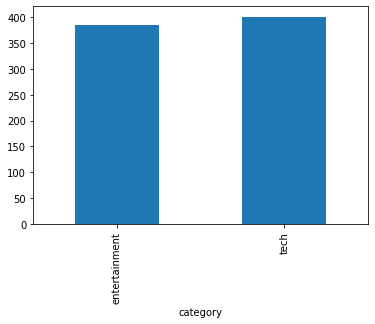

In [21]:
datapath = "/content/gdrive/MyDrive/Colab Notebooks/bbc_test.csv"
df_outside = pd.read_csv(datapath)
df_outside.groupby(['category']).size().plot.bar()
labels = {
          'entertainment':0,
          'tech':1,
          }

#Out-Of-Distribution data evaluation

In [22]:
test_batch_size = 12
probabilities_list_outside, logits_list_outside, test_label_list_outside = evaluate(model, df_outside, test_batch_size)

/usr/local/lib/python3.8/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Test Accuracy:  0.216 | Test Recall:  0.147 | Test Precision:  0.116 |Test AUC:  0.083


#Save Out-Of-Distribution softmax result

In [23]:
torch.save(probabilities_list_outside, '/content/gdrive/MyDrive/Colab Notebooks/probabilities_list_outside.pt')

#Save Out-Of-Distribution logits result

In [24]:
torch.save(logits_list_outside, '/content/gdrive/MyDrive/Colab Notebooks/logits_list_outside.pt')

#Save Out-Of-Distribution test labels result

In [25]:
torch.save(test_label_list_outside, '/content/gdrive/MyDrive/Colab Notebooks/test_label_list_outside.pt')

#Histogram - max(softmax)

In [26]:
import matplotlib.pyplot as plt

In [27]:
def get_hist_data_softmax(probabilities_list):
  hist_prob = []
  for i in range(len(probabilities_list)):
    probabilities_list[i] = probabilities_list[i].numpy(force=True)
    for j in range(len(probabilities_list[i])):
      hist_prob.append(probabilities_list[i][j].max())
  return hist_prob

In [28]:
hist_norm_softmax = get_hist_data_softmax(probabilities_list)
hist_outside_softmax = get_hist_data_softmax(probabilities_list_outside)
print(f"Seen elements histograms length: {len(hist_norm_softmax)}")
print(f"Unseen elements histograms length: {len(hist_outside_softmax)}")

Seen elements histograms length: 144
Unseen elements histograms length: 787


(array([  5.,  19.,  30.,  41.,  35.,  43.,  43.,  39.,  64.,  64., 105.,
        299.]),
 array([0.3458524 , 0.39701638, 0.44818035, 0.49934432, 0.55050826,
        0.60167223, 0.6528362 , 0.7040002 , 0.75516415, 0.8063281 ,
        0.8574921 , 0.90865606, 0.95982003], dtype=float32),
 <a list of 12 Patch objects>)

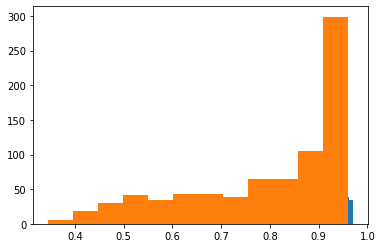

In [29]:
plt.hist(hist_norm_softmax, bins='auto')
plt.hist(hist_outside_softmax, bins='auto')

#Histogram - max(logits)

In [30]:
def get_hist_data_logit(logits_list):
  hist_prob = []
  for i in range(len(logits_list)):
    logits_list[i] = logits_list[i].numpy(force=True)
    for j in range(len(logits_list[i])):
      hist_prob.append(logits_list[i][j].max())
  return hist_prob

In [31]:
hist_norm_logit = get_hist_data_logit(logits_list)
hist_outside_logit = get_hist_data_logit(logits_list_outside)
print(f"Seen elements histograms length: {len(hist_norm_logit)}")
print(f"Unseen elements histograms length: {len(hist_outside_logit)}")

Seen elements histograms length: 144
Unseen elements histograms length: 787


(array([ 14.,  40.,  67.,  64.,  92.,  72.,  73.,  71.,  74., 138.,  82.]),
 array([-0.169977  ,  0.09220956,  0.3543961 ,  0.6165827 ,  0.8787692 ,
         1.1409558 ,  1.4031423 ,  1.6653289 ,  1.9275154 ,  2.189702  ,
         2.4518886 ,  2.714075  ], dtype=float32),
 <a list of 11 Patch objects>)

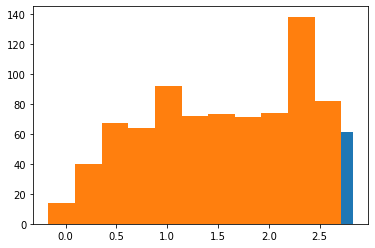

In [32]:
plt.hist(hist_norm_logit, bins='auto')
plt.hist(hist_outside_logit, bins='auto')

#Gaussian Discrete Analysis + Mahalanobis/Eucledian distance

In [33]:
def confidence(features: np.ndarray,
               means: np.ndarray,
               distance_type: str,
               cov: np.ndarray = None) -> np.ndarray:
    """
    Calculate mahalanobis or euclidean based confidence score for each class.
    Params:
        - features: shape (num_samples, num_features)
        - means: shape (num_classes, num_features)
        - cov: shape (num_features, num_features) or None (if use euclidean distance)
    
    Returns:
        - confidence: shape (num_samples, num_classes)
    """
    assert distance_type in ("euclidean", "mahalanobis")

    num_samples = features.shape[0]
    num_features = features.shape[1]
    num_classes = means.shape[0]
    if distance_type == "euclidean":
        cov = np.identity(num_features)
    
    features = features.reshape(num_samples, 1, num_features).repeat(num_classes, axis=1)  # (num_samples, num_classes, num_features)
    means = means.reshape(1, num_classes, num_features).repeat(num_samples, axis=0)  # (num_samples, num_classes, num_features)
    vectors = features - means  # (num_samples, num_classes, num_features)
    cov_inv = np.linalg.inv(cov)
    bef_sqrt = np.matmul(np.matmul(vectors.reshape(num_samples, num_classes, 1, num_features), cov_inv),
                         vectors.reshape(num_samples, num_classes, num_features, 1)).squeeze()
    result = np.sqrt(bef_sqrt)
    result[np.isnan(result)] = 1e12  # solve nan
    return result

In [34]:
feature_train = logits_list[0].copy()
feature_test = logits_list_outside[0].copy()
y_train_seen = test_label_list[0].numpy(force=True).copy()

In [35]:
feature_train

array([[-1.4145838 ,  2.6957393 , -1.2993461 ],
       [-1.5708884 ,  2.5394304 , -1.2662697 ],
       [ 2.4298723 , -1.6211356 , -0.9977237 ],
       [-1.1424605 , -1.7533209 ,  1.9707327 ],
       [-1.5708666 ,  2.4001558 , -1.2886676 ],
       [-1.6107861 ,  2.6833632 , -1.1704907 ],
       [ 2.6324    , -1.338116  , -1.0930086 ],
       [-1.4386296 , -1.6394459 ,  1.9738065 ],
       [ 2.104524  , -1.2256024 , -1.1204535 ],
       [ 2.5088449 , -1.2834251 , -0.91278833],
       [-1.4515046 , -1.5854211 ,  1.9693402 ],
       [ 2.5922208 , -1.3809282 , -1.1528244 ]], dtype=float32)

In [36]:
feature_test

array([[ 1.557283  , -1.4079994 , -0.74512714],
       [-0.9139955 , -1.2857493 ,  1.186756  ],
       [-1.3892535 , -1.300934  ,  1.710266  ],
       [ 0.24553593, -1.6553401 ,  0.7028428 ],
       [ 2.5182347 , -1.2676266 , -1.0703173 ],
       [-0.5700985 , -0.7926932 ,  0.5403333 ],
       [ 2.5182347 , -1.2676266 , -1.0703173 ],
       [ 1.2419082 , -0.7853922 , -0.90924907],
       [ 2.5996494 , -1.3789781 , -1.1156573 ],
       [ 0.37697667, -1.702316  ,  0.6843248 ],
       [-0.45363015, -0.7097584 ,  0.36875457],
       [-1.4707719 , -0.8185944 ,  1.3230923 ]], dtype=float32)

In [37]:
y_train_seen

array([1, 1, 0, 2, 1, 1, 0, 2, 0, 0, 2, 0])

In [38]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

solver = "lsqr"
distance_type = "mahalanobis" # "euclidean"
assert solver in ("lsqr")
assert distance_type in ("mahalanobis", "euclidean")

gda = LinearDiscriminantAnalysis(solver=solver, shrinkage=None, store_covariance=True)
gda.fit(feature_train, y_train_seen)


y_pred = gda.predict(feature_test)
gda_result_test = confidence(feature_test, gda.means_, distance_type, gda.covariance_)
y_pred_score = pd.Series(gda_result_test.min(axis=1))

threshold = 2.2
y_pred_score[y_pred_score[y_pred_score > threshold].index] = 'unseen'

In [41]:
gda_result_test

array([[ 7.93086309, 37.23403906, 46.99188716],
       [41.81874416, 50.07554537, 13.11460875],
       [50.4582202 , 56.82175489,  5.06621963],
       [31.65004197, 47.07433825, 22.57257825],
       [ 1.11803293, 38.60733285, 54.74643214],
       [32.11034038, 39.81350046, 24.41463241],
       [ 1.11803293, 38.60733285, 54.74643214],
       [ 9.06677913, 31.621803  , 49.37980624],
       [ 1.36777101, 39.54602483, 55.48500671],
       [31.03041683, 47.2707926 , 23.23292328],
       [29.59804379, 37.49807735, 27.32582243],
       [45.47957828, 49.57944501, 12.32368029]])

In [42]:
y_pred_score

0      7.930863
1     13.114609
2      5.066220
3     22.572578
4      1.118033
5     24.414632
6      1.118033
7      9.066779
8      1.367771
9     23.232923
10    27.325822
11    12.323680
dtype: float64

In [45]:
y_pred_score[y_pred_score[y_pred_score > threshold].index] = 'unseen'

In [46]:
y_pred_score

0       unseen
1       unseen
2       unseen
3       unseen
4     1.118033
5       unseen
6     1.118033
7       unseen
8     1.367771
9       unseen
10      unseen
11      unseen
dtype: object

In [47]:
y_pred

array([0, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2])

In [48]:
y_train_seen

array([1, 1, 0, 2, 1, 1, 0, 2, 0, 0, 2, 0])